# start

In [1]:
PRFX='0320_1'
trntmstmp=1584412344
valtmstmp=1584626395
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-19 13:59:55']

In [2]:
grand_total=1.5e8

# setup

In [33]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [9]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [10]:
def prp_df(df, istrn=True):
    df['len_toks']=df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_month']=tm_dt.dt.month
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_day']=tm_dt.dt.day
    df['tm_hour']=tm_dt.dt.hour
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'twtid', 'u1id', 'u2id']+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'u1id',])        
    return df

In [11]:
grand_total

150000000.0

In [12]:
grand_total/1e6

150.0

In [13]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-20 12:07:00 chunk 0


In [14]:
df = pd.concat(lst_df)

In [15]:
df.shape

(1000000, 97)

In [16]:
df.columns

Index(['tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed', 'u1_create_tm',
       'u2_follower_cnt', 'u2_following_cnt', 'u2_vrfed', 'u2_create_tm',
       'u1_fllw_u2', 'len_toks', 'has_media_Photo', 'has_media_Video',
       'has_media_GIF', 'num_hshtgs', 'num_links', 'num_domns', 'tm_month',
       'tm_dayofweek', 'tm_day', 'tm_hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
       'lang_975B38F44D6

In [17]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [18]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 243 ms, sys: 379 ms, total: 622 ms
Wall time: 630 ms


In [19]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((850000, 93), (150000, 93), (850000, 4), (150000, 4))

# model

In [38]:
params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss'],
#     https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
#     'max_delta_step': 1,
}
num_rounds = 100


In [39]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-20 13:34:27 Retweet ********************************************************************************
[13:34:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.11053	train-logloss:0.53311	eval-error:0.11124	eval-logloss:0.53347
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[13:34:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.11016	train-logloss:0.44794	eval-error:0.11111	eval-logloss:0.44842
[13:34:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-error:0.11011	train-logloss:0.39835	eval-error:0.11103	eval-logloss:0.39909
[13:34:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6


[13:35:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.10843	train-logloss:0.30650	eval-error:0.10985	eval-logloss:0.31209
[13:35:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.10838	train-logloss:0.30635	eval-error:0.10985	eval-logloss:0.31205
[13:35:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.10837	train-logloss:0.30619	eval-error:0.10986	eval-logloss:0.31201
[13:35:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-error:0.10835	train-logloss:0.30611	eval-error:0.10983	eval-logloss:0.31198
[13:35:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-error:0.10834	train-logloss:0.30603	ev

[13:35:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[79]	train-error:0.10750	train-logloss:0.30167	eval-error:0.10990	eval-logloss:0.31069
[13:35:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-error:0.10750	train-logloss:0.30151	eval-error:0.10990	eval-logloss:0.31070
[13:35:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.10747	train-logloss:0.30146	eval-error:0.10991	eval-logloss:0.31071
[13:35:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[82]	train-error:0.10747	train-logloss:0.30142	eval-error:0.10991	eval-logloss:0.31072
[13:35:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[83]	train-error:0.10744	train-logloss:0.30136	eval

[13:36:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[29]	train-error:0.02776	train-logloss:0.11000	eval-error:0.02715	eval-logloss:0.11166
[13:36:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[30]	train-error:0.02775	train-logloss:0.10981	eval-error:0.02715	eval-logloss:0.11163
[13:36:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[31]	train-error:0.02775	train-logloss:0.10973	eval-error:0.02715	eval-logloss:0.11162
[13:36:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[32]	train-error:0.02775	train-logloss:0.10967	eval-error:0.02715	eval-logloss:0.11162
[13:36:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[33]	train-error:0.02775	train-logloss:0.10954	eva

[13:36:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[69]	train-error:0.02768	train-logloss:0.10657	eval-error:0.02717	eval-logloss:0.11146
[13:36:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[70]	train-error:0.02767	train-logloss:0.10646	eval-error:0.02717	eval-logloss:0.11146
[13:36:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[71]	train-error:0.02767	train-logloss:0.10640	eval-error:0.02716	eval-logloss:0.11146
[13:36:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[72]	train-error:0.02767	train-logloss:0.10636	eval-error:0.02716	eval-logloss:0.11146
[13:36:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[73]	train-error:0.02767	train-logloss:0.10629	eva

[13:37:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[32]	train-error:0.31705	train-logloss:0.59348	eval-error:0.32296	eval-logloss:0.59904
[13:37:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[33]	train-error:0.31696	train-logloss:0.59330	eval-error:0.32279	eval-logloss:0.59898
[13:37:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[34]	train-error:0.31668	train-logloss:0.59276	eval-error:0.32221	eval-logloss:0.59852
[13:37:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[35]	train-error:0.31606	train-logloss:0.59217	eval-error:0.32206	eval-logloss:0.59803
[13:37:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[36]	train-error:0.31593	train-logloss:0.59202	ev

[13:37:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[72]	train-error:0.30870	train-logloss:0.58299	eval-error:0.31739	eval-logloss:0.59220
[13:38:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[73]	train-error:0.30858	train-logloss:0.58281	eval-error:0.31743	eval-logloss:0.59213
[13:38:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[74]	train-error:0.30847	train-logloss:0.58269	eval-error:0.31734	eval-logloss:0.59212
[13:38:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[75]	train-error:0.30845	train-logloss:0.58261	eval-error:0.31735	eval-logloss:0.59206
[13:38:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[76]	train-error:0.30838	train-logloss:0.58255	eva

[13:38:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[11]	train-error:0.00777	train-logloss:0.04856	eval-error:0.00759	eval-logloss:0.04818
[13:38:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[12]	train-error:0.00777	train-logloss:0.04660	eval-error:0.00759	eval-logloss:0.04627
[13:38:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[13]	train-error:0.00777	train-logloss:0.04528	eval-error:0.00759	eval-logloss:0.04501
[13:38:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[14]	train-error:0.00777	train-logloss:0.04441	eval-error:0.00759	eval-logloss:0.04422
[13:38:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[15]	train-error:0.00777	train-logloss:0.04383	

In [40]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


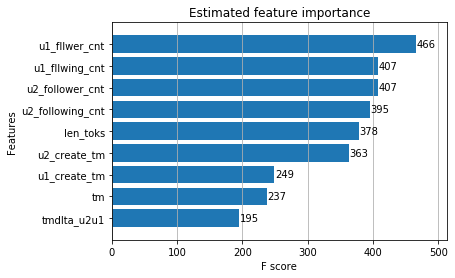

,0,1
6,u1_fllwer_cnt,466
15,u1_fllwing_cnt,407
1,u2_follower_cnt,407
9,u2_following_cnt,395
7,len_toks,378
13,u2_create_tm,363
18,u1_create_tm,249
21,tm,237
16,tmdlta_u2u1,195
22,tmdlta_twtu1,145


Reply


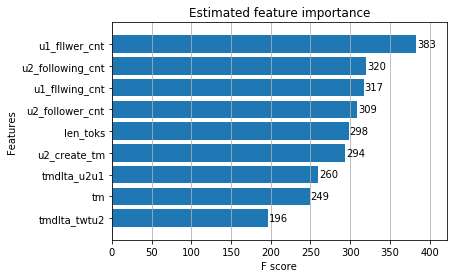

,0,1
8,u1_fllwer_cnt,383
5,u2_following_cnt,320
11,u1_fllwing_cnt,317
17,u2_follower_cnt,309
4,len_toks,298
14,u2_create_tm,294
15,tmdlta_u2u1,260
3,tm,249
2,tmdlta_twtu2,196
6,u1_create_tm,188


Like


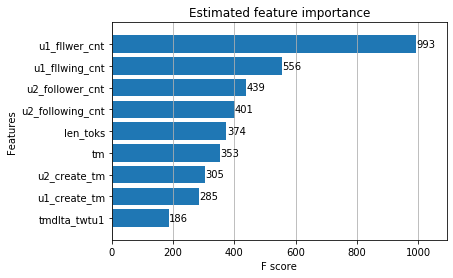

,0,1
5,u1_fllwer_cnt,993
17,u1_fllwing_cnt,556
6,u2_follower_cnt,439
8,u2_following_cnt,401
2,len_toks,374
10,tm,353
3,u2_create_tm,305
9,u1_create_tm,285
12,tmdlta_u2u1,186
13,tmdlta_twtu1,186


RTwCmnt


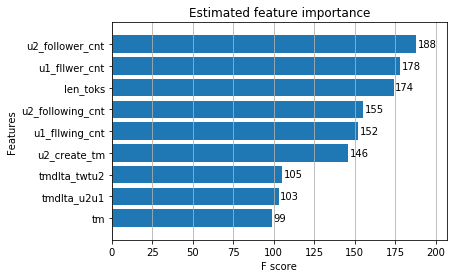

,0,1
0,u2_follower_cnt,188
11,u1_fllwer_cnt,178
8,len_toks,174
12,u2_following_cnt,155
17,u1_fllwing_cnt,152
4,u2_create_tm,146
3,tmdlta_twtu2,105
5,tmdlta_u2u1,103
6,tm,99
15,u1_create_tm,73


In [41]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

## valid

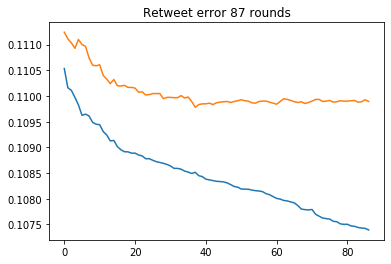

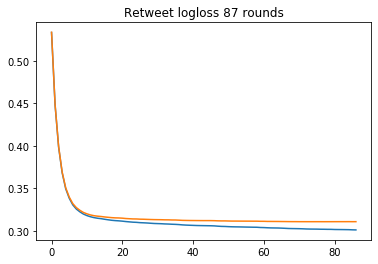

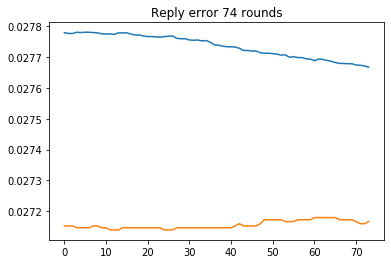

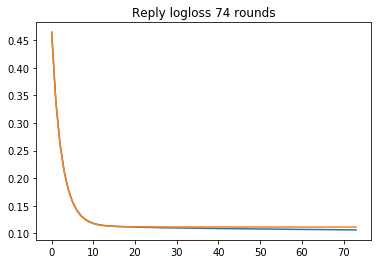

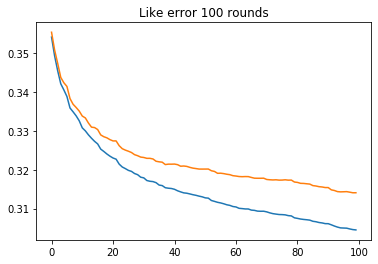

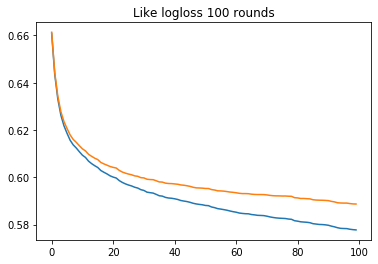

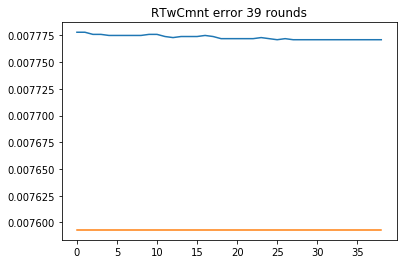

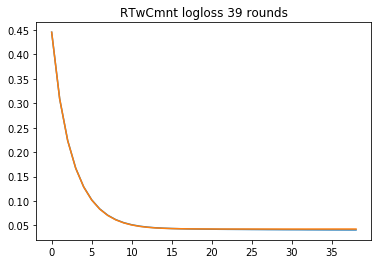

In [48]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()

In [44]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-20 13:39:04 Retweet
2020-03-20 13:39:04 Reply
2020-03-20 13:39:05 Like
2020-03-20 13:39:05 RTwCmnt


In [45]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7651 valid auc: 0.7426
train prauc: 0.3548 valid auc: 0.3141
train rce: 14.7339 valid rce: 12.1765
Reply
train rocauc: 0.8192 valid auc: 0.7700
train prauc: 0.1723 valid auc: 0.0920
train rce: 16.3578 valid rce: 10.5661
Like
train rocauc: 0.7581 valid auc: 0.7439
train prauc: 0.7073 valid auc: 0.6896
train rce: 15.7489 valid rce: 14.0889
RTwCmnt
train rocauc: 0.7834 valid auc: 0.6962
train prauc: 0.0632 valid auc: 0.0173
train rce: 10.1568 valid rce: 4.0695


In [46]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.354813,14.7339,0.17228,16.3578,0.70728,15.7489,0.0632438,10.1568
scrval,0.314137,12.1765,0.0919746,10.5661,0.689583,14.0889,0.0173482,4.06954


# infer

In [22]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 44s, sys: 12.6 s, total: 1min 57s
Wall time: 4min 11s


In [23]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 57s, sys: 14.1 s, total: 2min 11s
Wall time: 2min 31s


In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 07:20:44 Retweet
2020-03-20 07:20:51 Reply
2020-03-20 07:20:52 Like
2020-03-20 07:21:00 RTwCmnt
CPU times: user 6min 13s, sys: 51.3 s, total: 7min 4s
Wall time: 3min 50s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 07:21:04 Retweet
2020-03-20 07:22:02 Reply
2020-03-20 07:23:00 Like
2020-03-20 07:23:57 RTwCmnt
CPU times: user 3min 43s, sys: 6.89 s, total: 3min 49s
Wall time: 3min 50s
